In [1]:
import cv2 
import pytesseract
pytesseract.pytesseract.tesseract_cmd=r'C:\Users\Dicks\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
# Getting vocab and tokenizers [src->trg]
with open('.data/en_to_de_vocab_token.pkl', 'rb') as f:  
    vocab_en, vocab_de, en_tokenizer, de_tokenizer = pickle.load(f)
import torch
from attention_transformer import Transformer
import torch.nn as nn
SRC_VOCAB_SIZE ,TRG_VOCAB_SIZE = len(vocab_en) , len(vocab_de)
SRC_PAD_IDX, TRG_PAD_IDX = vocab_en['<PAD>'] , vocab_de['<PAD>']
MAX_SENTENCE_LENGTH = 256
EMBED_SIZE , NUM_LAYERS , FORWARD_EXPANSION , HEADS = 256, 3, 2 , 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DROPOUT = 0.1

model = Transformer(
    src_vocab_len=SRC_VOCAB_SIZE,
    trg_vocab_len=TRG_VOCAB_SIZE,
    src_pad_idx = SRC_PAD_IDX,
    trg_pad_idx = TRG_PAD_IDX,
    src_max_sentence_len = MAX_SENTENCE_LENGTH,
    trg_max_sentence_len = MAX_SENTENCE_LENGTH,
    hid_dim = EMBED_SIZE,
    n_layers = NUM_LAYERS,
    n_heads = HEADS,
    ff_dim_multiplier = FORWARD_EXPANSION,
    dropout = DROPOUT,
    device = DEVICE
).to(DEVICE)


# Loading params for model
model.load_state_dict(torch.load('model_dicts/en_ger_attention_model.pt'))

def translate_sentence(sentence, src_tokenizer, src_vocab, trg_vocab, model, device,max_len = 100):
    model.eval()
    
    src_tokens = ['<BOS>'] + [token.text.lower() for token in src_tokenizer(sentence)] + ['<EOS>']
    src_indexes = [src_vocab[token] for token in src_tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    trg_indexes = []
    trg_indexes.append(trg_vocab['<BOS>'])

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(src_tensor,trg_tensor)
        
        pred_token = output.cpu().argmax(2)[:,-1]
        
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<EOS>']:
            break
    
    trg_tokens = [trg_vocab.lookup_token(i) for i in trg_indexes]
    #print(trg_tokens)
    """Memory Management"""
    output = output.cpu()
    del output
    return trg_tokens


In [3]:
def img_to_text(img_file_dir):
    img = cv2.imread(img_file_dir)
    text = pytesseract.image_to_string(img)
    im = np.array(img)
    plt.imshow(im, interpolation='nearest')
    plt.show()
    return text

In [4]:
def img_to_german(img_file_dir):
    text = img_to_text(img_file_dir)
    
    translation = translate_sentence(sentence = text,
                                 src_tokenizer = en_tokenizer,
                                 src_vocab = vocab_en, 
                                 trg_vocab = vocab_de,
                                 model = model,
                                 device = DEVICE,
                                 max_len = 100
                                )
    
    print('Image text',text)
    print('\n\nGerman text', " ".join(translation[1:-1]))

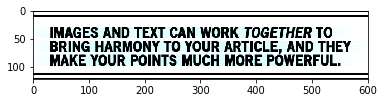

Image text  

 

IMAGES AND TEXT CAN WORK TOGETHER TO
BRING HARMONY TO YOUR ARTICLE, AND THEY
MAKE YOUR POINTS MUCH MORE POWERFUL.

 

 



German text <UNK> und text können zusammen arbeiten , um ihren artikel zu harmonie zu bringen , und sie machen ihre großen <UNK> zu viel <UNK> punkten . 



In [14]:
img_to_german("test_images/test1.png")

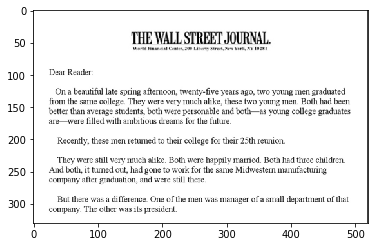

Image text  

 

Dear Reader:

na beautifl late spring aftemoon, twenty-five years ago, two young men graduated
from the same college. They were very much alike, these two young men. Both had been
better than average students, both were personable and both—as young college graduates
are—were filled with ambitious dreams forthe future.

Recently, these men retumed to their college for their 25th reunion.

‘They were still very much alike. Both were happily married. Both had three children.
‘And both, it tumed out, had gone to work for the same Midwestem manufacturing
company after graduation, and were stil there.

But there was a difference, One of the men was manager of a small department of that
‘company. The other was its president

 



German text <UNK> : <UNK> , <UNK> <UNK> <UNK> <UNK> , vor zwei jahren , waren beide sehr viel <UNK> , zwei männer , die zwei <UNK> waren . das waren beide <UNK> , zwei <UNK> , und die waren beide <UNK> , die zwei <UNK> , die sich für die <UNK> hatte

In [6]:
img_to_german("test_images/test2.png")

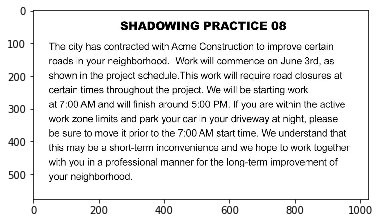

Image text SHADOWING PRACTICE 08

The city has contracted with Acme Construction to improve certain
roads in your neighborhood. Work will commence on June 3rd, as
shown in the project schedule. This work will require road closures at
certain times throughout the project. We will be starting work

at 7:00 AM and will finish around 5:00 PM. If you are within the active
work zone limits and park your car in your driveway at night, please
be sure to move it prior to the 7:00 AM start time. We understand that
this may be a short-term inconvenience and we hope to work together
with you in a professional manner for the long-term improvement of
your neighborhood.



German text <UNK> praktizieren die stadt mit <UNK> , um die <UNK> in ihrer nachbarschaft zu verbessern . im juni , wie sie in diesem projekt <UNK> arbeiten , werden wir in der zeit mit sicherheit zusammenarbeiten und in der <UNK> arbeiten . 



In [7]:
img_to_german("test_images/test4.jpg")

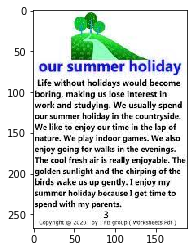

Image text our summer holiday
Life without holidays would become
boring, making us lose interest in
work and studying, We usually spend
our summer holiday i the countryside.
We like to enjoy our time inthe lap of
nature. We play indoor games. We also
enjoy going for walks in the evenings.
The cool fresh air is really enjoyable. The
golden sunlight and the chirping ofthe
birds wake us up gently. enjoy my
summer holiday because I get time to
spend with my parents.

 

 

 



German text unser <UNK> leben ohne <UNK> , die uns im <UNK> zu hause zu verlieren , und wir verbringen die zeit , in der <UNK> zu spielen . wir lieben es , die <UNK> zu spielen . 



In [8]:
img_to_german("test_images/test3.png")

In [9]:
# My model only can translate up to 100 words. As Taking 256 words will be too much Memory. Hence, This is what it can translately only.


In [13]:
translation = translate_sentence(sentence = 'Hello My name is Dickson, What is your name? Good Afternoon, I hope u enjoyed the demo',
                                 src_tokenizer = en_tokenizer,
                                 src_vocab = vocab_en, 
                                 trg_vocab = vocab_de,
                                 model = model,
                                 device = DEVICE,
                                 max_len = 100
                                )
print(translation)

['<BOS>', 'hallo', 'mein', 'name', 'ist', '<UNK>', ',', 'was', 'ist', 'ihr', 'name', '?', 'guten', 'tag', '?', 'ich', 'hoffe', ',', 'dass', 'ich', 'den', 'menschenaffen', 'von', 'gestern', 'wünschte', ',', 'dass', 'ich', 'die', 'demo', 'wünschte', ',', 'die', 'demo', 'wünschte', ',', 'die', 'zeigen', 'würde', '.', '\n', '<EOS>']
